Simulation of moving bar with two cell types and delayed feedback
July 28, 2020 created by CKC
based on NF_MB_02 but with a smooth moving bar by using a stimulation with continuous position

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [25]:
def K(x,s):
    return(np.exp(-(x/s)**2))

In [70]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [26]:
klen = 80
hw = 30
xx = np.arange(klen)

sigma_c = 30
sigma_h = 40

kcxs = K(xx,sigma_c)
khxs = K(xx,sigma_h)
KH = np.zeros(klen*2-1)
KC = np.zeros(klen*2-1)
tmp = khxs[::-1]
KH[0:klen]= tmp[0:klen]
KH[klen:2*klen]=khxs[1:klen]

tmp = kcxs[::-1]
KC[0:klen]= tmp[0:klen]
KC[klen:2*klen]=kcxs[1:klen]
CS=KC-0.3*KH

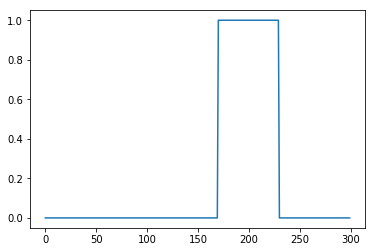

In [56]:
xlen = 300 #spatial extend of simulation
i0 = 200
s = np.zeros(xlen)
s[i0-hw:i0+hw] = 1
plt.plot(s)

In [57]:
# Guassian function with mean x0 and standard deviation sigma
def G(x,x0,sigma):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = np.exp(-((x[i]-x0)/sigma)**2)
    return(y)

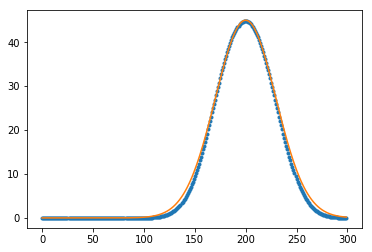

In [58]:
# macthing with Gussian profile with convoluted result

r = np.convolve(s,KC,'same')
plt.plot(r,'.')
tempx = np.arange(xlen)
tempy = 45*G(tempx,i0,sigma_c*1.4) # this form will be used for stimulation
plt.plot(tempy)

In [85]:
#main
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma=4.5
Omega =Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

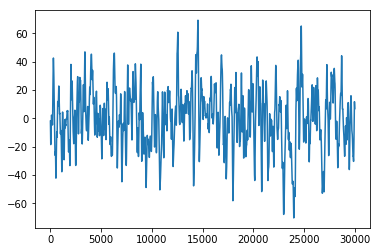

In [86]:
plt.plot(LPOU/50)

In [120]:
dt = 0.01

alpha = 80
beta = 2

k = 400
g = 1/20

pos_0 = 150
nstep = 10000
v = 10 # moving bar velocity
#v = 0

y = np.zeros(xlen) # cone cell output
z = np.zeros(xlen) # horizontal cell output


speak = np.zeros(nstep)
rpeak = np.zeros(nstep)

stm = []
rsp = []
zts = []
tmp = []

for i in range(nstep):
    #s = np.zeros(xlen)            # stimulation array
    #d = int(v*i)                  # distance travelled by the moving bar
    #speak[i]= i0+d                # peak position of stimulatino
    #s[i0+d-hw:i0+hw+d] = 1        # stimualation turned on for the bar position
    #rs = np.convolve(s,KC,'same') # stimulation (s) convoluted with cone receptive field KC
    pos = pos_0+LPOU[i]/20
    speak[i] = pos
    rs =  45*G(tempx,pos,sigma_c*1.4)
    ry = np.convolve(y,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    
    for j in range(xlen):
        dyj =(-alpha*y[j]+k*(rs[j]-z[j]))*dt
        dzj =(-beta*z[j]+g*ry[j])*dt
        y[j] = y[j]+dyj
        z[j] = z[j]+dzj
    maxpos = np.argmax(y)
    rpeak[i]= maxpos
    
    stm.append(rs.copy())
    rsp.append(y.copy())
    zts.append(z.copy())
    
    if i%500 == 0:
        #plt.plot(y[maxpos-50:maxpos+50])
        #plt.plot(y)
        #tmp.append(y)
        #plt.plot(rs/7)
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


(-59, 341)

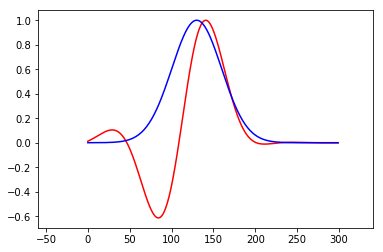

In [121]:
plt.plot(y/np.max(y),'r')
plt.plot(rs/np.max(rs),'b')
#plt.plot(z)
plt.xlim([maxpos-200,maxpos+200])

In [122]:
# activation function
def A(x,theta):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

(41, 241)

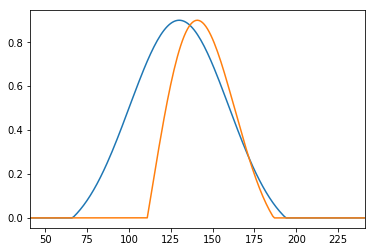

In [123]:
# shown with activatin function
rrs = rs/np.max(rs)
yy = y/np.max(y)
plt.plot(A(rrs,0.1))
plt.plot(A(yy,0.1))
plt.xlim([maxpos-100,maxpos+100])

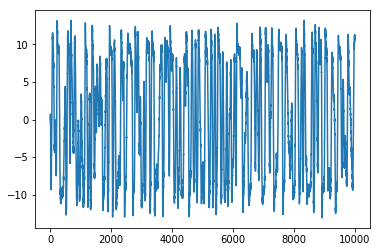

In [124]:
# difference between stimualtion and response peak
plt.plot(rpeak-speak)

#plt.ylim([0,15])
#plt.xlim([350,450])

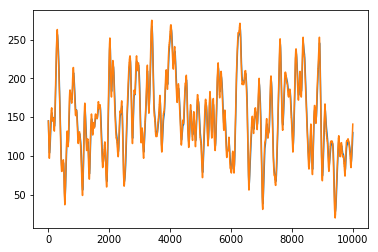

In [125]:
plt.plot(speak)
plt.plot(rpeak)

In [126]:
dms = range(-49,50)
mi_ss = [mi_quick(speak,speak,d) for d in dms]
mi_sr = [mi_quick(speak,rpeak,d) for d in dms]


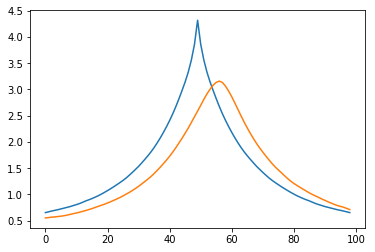

In [127]:
plt.plot(mi_ss)
plt.plot(mi_sr)

In [128]:
index = 100
yy = np.zeros(nstep)
for i in range(nstep):
    yy[i] = rsp[i][index]

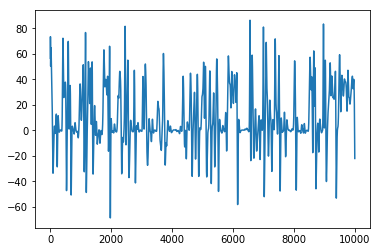

In [129]:
plt.plot(yy)

In [130]:
dms = range(-49,50)
mi_ss = [mi_quick(speak,speak,d) for d in dms]
mi_sr = [mi_quick(speak,rpeak,d) for d in dms]
mi_syy = [mi_quick(speak,yy,d) for d in dms]

(0, 5)

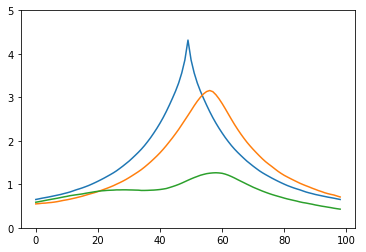

In [131]:
plt.plot(mi_ss)
plt.plot(mi_sr)
plt.plot(np.array(mi_syy))
plt.ylim([0,5])

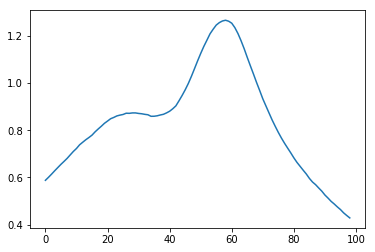

In [132]:
plt.plot(mi_syy)